# Tutorial 05: Collision Checks With Dynamic Obstacles

This tutorial shows you how to use the drivability checker library in order to quickly check if multiple ego-vehicle trajectories collide
with a set of dynamic obstacles.


## 1. Necessary imports
We begin by importing all necessary modules.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

# commonocean-io
from commonocean.prediction.prediction import TrajectoryPrediction, SetBasedPrediction
from commonocean.visualization.draw_dispatch_cr import draw_object
from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.scenario.trajectory import Trajectory
from commonocean.scenario.state import GeneralState
from commonocean.scenario.obstacle import ObstacleType, DynamicObstacle

from commonroad.geometry.shape import Rectangle
from commonroad.visualization.mp_renderer import MPRenderer
import commonroad_dc.pycrcc as pycrcc

# commonocean-dc
from commonocean_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object
from commonocean_dc.boundary import boundary
from commonocean_dc.collision.trajectory_queries import trajectory_queries

## 2. Collision checks
We demonstrate the collision checking for the example of CommonOcean scenario.

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


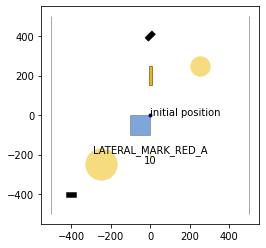

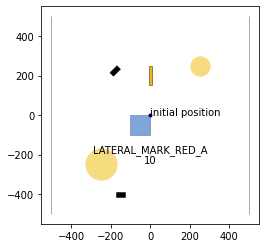

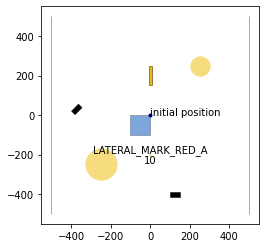

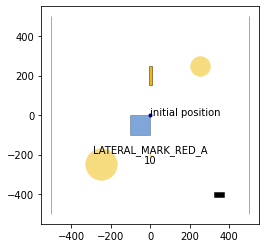

In [2]:
# scenario names for both considered scenarios
scenario_name_trajectory_prediction='CommonOceanDC_Tutorial.xml'

scenario, planning_problem_set = CommonOceanFileReader(scenario_name_trajectory_prediction).open()

for j in [0,50, 105, 150]:
    draw_object(scenario, draw_params={'time_begin': j, 'trajectory_steps': 0})
    draw_object(planning_problem_set, draw_params={'time_begin': j})
    plt.gca().set_aspect('equal')
    plt.show()

The first thing to be done is get the trajectories of the 2 dynamic obstacles that we have in this example scenario and transform it in a time-variant collision object.

The function `get_scenario_dynamic_obstacles_list()` returns the dynamic obstacles in the scenario as a list of Time-Variant
Collision Objects.

In [3]:
def get_scenario_dynamic_obstacles_list(scenario):
    dyn_obstacles_list=list()
    for dyn_obst in scenario.dynamic_obstacles:
        if isinstance(dyn_obst.prediction,TrajectoryPrediction):
            co=create_collision_object(dyn_obst.prediction)
            # preprocess using obb hull for continuous collision detection
            co, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
            dyn_obstacles_list.append(co)
        else:
            if isinstance(dyn_obst.prediction,SetBasedPrediction):
                co=create_collision_object(dyn_obst.prediction)
                dyn_obstacles_list.append(co)    
            else:
                raise Exception('Unknown dynamic obstacle prediction type: ' + str(type(dyn_obst.prediction))) 
    return dyn_obstacles_list

In [4]:
trajectories = get_scenario_dynamic_obstacles_list(scenario)

After loading the trajectory batch, we create the waters boundary (see *Tutorial 03: road compliance checking* for details).
The scenario and its boundary are visualized below.

start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]
start: [[ 500. -500.]
 [-500. -500.]],left: [[-500. -500.]
 [-500.    0.]
 [-500.  500.]],end: [[-500.  500.]
 [ 500.  500.]],right: [[ 500.  500.]
 [ 500.    0.]
 [ 500. -500.]]


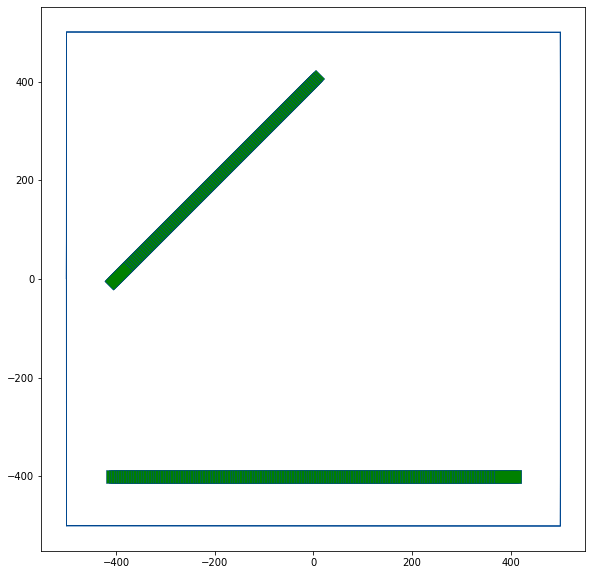

In [5]:
waters_boundary_obstacle, waters_boundary_sg_triangles=boundary.create_waters_boundary_obstacle(scenario, method='triangulation')
waters_polygons = boundary.create_waters_polygons(scenario, method='whole_polygon', triangulate=False)

# Draw an exemplary part of trajectories (here: 2 trajectories) and the road boundary

rnd = MPRenderer(figsize=(25, 10))
waters_boundary_sg_triangles.draw(rnd)
for tvo in trajectories:
    rnd.draw_params.shape.facecolor = "green"
    tvo.draw(rnd)
rnd.render()

## 2.1. Check if trajectory is within the road (static collision checking)
We can check the trajectory batch for waters-compliance by performing a static collision check with the waters boundary, as
demonstrated in *Tutorial 03: road compliance checking*.

In [6]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    valid_trajectories = 0
    ret=trajectory_queries.trajectories_collision_static_obstacles(trajectories, waters_boundary_sg_triangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)
cur_time_2 = time()

print("%s out of %s checked trajectories don't collide with the road boundary." % (ret.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

2 out of 2 checked trajectories don't collide with the road boundary.
Time for 2 trajectory checks: 0.00015048980712890626 sec.


## 2.2. Dynamic collision checking

Now we must check if the vessels are colliding with each other during the scenario flow. For that, let's create a dynamic_obstacle as reference of collision (we're going to compare our trajectories with this new dynamic obstacle)

In [7]:
# Creating dynamic obstacle
# (please check the CommonOcean-io to understand how to create a new dynamic obstacle from scratch)

initial_positions_dynamic_obstacles = [np.array([400,-400])]
goal_positions_dynamic_obstacles = [np.array([-400,-400])]
velocities_dynamic_obstacles = [5]
length_dynamic_obstacles = [50]
fraction_width_dynamic_obstacles = [2]
dt = 1

for n in range(1):

    initial_position_dynamic_obstacle = initial_positions_dynamic_obstacles[n]
    goal_center_dynamic_obstacle = goal_positions_dynamic_obstacles[n]
    velocity = velocities_dynamic_obstacles[n]
    heading = 3.141621
    dynamic_obstacle_initial_state = GeneralState(**{'position': initial_position_dynamic_obstacle, 'orientation': heading, 'time_step': 0, 'velocity': velocity})
    dynamic_obstacle_state_list = [dynamic_obstacle_initial_state]
    t_max_dynamic_obstacle = (np.linalg.norm(goal_center_dynamic_obstacle-initial_position_dynamic_obstacle)) / velocity
    t_end_dynamic_obstacle = int(t_max_dynamic_obstacle / dt)

    for t_i in range(1,t_end_dynamic_obstacle):
        # Computing new position
        new_position = dynamic_obstacle_state_list[-1].position + \
                    np.array([dynamic_obstacle_state_list[-1].velocity * scenario.dt * np.cos(dynamic_obstacle_state_list[-1].orientation),
                                dynamic_obstacle_state_list[-1].velocity * scenario.dt * np.sin(dynamic_obstacle_state_list[-1].orientation)])

        # Adding new state to dynamic_obstacle_state_list
        acceleration = 0
        dynamic_obstacle_state_list.append(GeneralState(**{'position': new_position, 'orientation': heading,'time_step': t_i, 'velocity': velocity, 'acceleration': acceleration}))

    # Creating the predicted trajectory starting at time step 1
    dynamic_obstacle_trajectory = Trajectory(initial_time_step=1, state_list=dynamic_obstacle_state_list[1:])

    # Creating the prediction using the predicted trajectory and the shape of the obstacle
    length = length_dynamic_obstacles[n]
    dynamic_obstacle_shape = Rectangle(length=length, width=length/fraction_width_dynamic_obstacles[n])
    dynamic_obstacle_prediction = TrajectoryPrediction(trajectory=dynamic_obstacle_trajectory,shape=dynamic_obstacle_shape)

    # Generating the dynamic obstacle according to the specification
    dynamic_obstacle_id = scenario.generate_object_id()
    dynamic_obstacle_type = ObstacleType.MOTORVESSEL
    dynamic_obstacle = DynamicObstacle(obstacle_id=dynamic_obstacle_id, obstacle_type=dynamic_obstacle_type,
                                obstacle_shape=dynamic_obstacle_shape, initial_state=dynamic_obstacle_initial_state,
                                prediction=dynamic_obstacle_prediction)

    # Adding dynamic obstacle to the scenario
    scenario.add_objects(dynamic_obstacle)

We created one vessel that directly collides with the dynamic obstacle in the bottom of our scenario, as you may see in the next plot.

/home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_sign.py:159: UserWarning: No png file for traffic sign id TrafficSignElementID.LATERAL_MARK_RED_A exists under path /home/maioneb/.conda/envs/co38/lib/python3.8/site-packages/commonocean/visualization/traffic_signs/101.png, skipped plotting.
  warnings.warn(


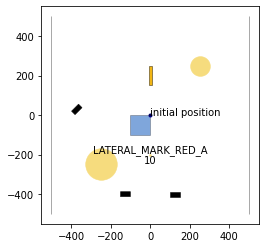

In [8]:
draw_object(scenario, draw_params={'time_begin': 105, 'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': 105})
plt.gca().set_aspect('equal')
plt.show()

In [9]:
# Selecting only the last dyn obstacle as reference
reference_dynamic_obstacles = [get_scenario_dynamic_obstacles_list(scenario)[-1]]

In [10]:
# check computation time over ten runs
num_trials=10

cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, reference_dynamic_obstacles, method='box2d')
cur_time_2 = time()

print("%s out of %s trajectories don't collide with the other vessels" % (res_dynamic.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

1 out of 2 trajectories don't collide with the other vessels
Time for 2 trajectory checks: 0.0003496408462524414 sec.


We obtained the expected result: only one of our trajectories collides with the referenced dynamic obstacle that we artificially created. If you want to have a more practical application and test the dynamic obstacles between themselves (without a fictional obstacle), it's simple and the idea is the same, we must only select the reference of dynamic obstacle and compare with the trajectory, as shown in the next cell.

In [11]:
reference_dynamic_obstacles = [trajectories[1]]
trajectories = [trajectories[0]]

num_trials=10

cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, reference_dynamic_obstacles, method='box2d')
cur_time_2 = time()

print("%s out of %s trajectories don't collide with the other vessels" % (res_dynamic.count(-1), len(trajectories)))
print("Time for %s trajectory checks: " % (len(trajectories)) + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

1 out of 1 trajectories don't collide with the other vessels
Time for 1 trajectory checks: 0.0003221988677978516 sec.


As expected, the two initial vessels don't collide between them.
The logic to test scenarios with more than 2 vessels is the same: just be careful to select the reference obstacles and remove them from the tested trajectories, otherwise you will certainly have collision (a vessel always collide with itself).